In [3]:
# in jupyter notebooks, normal install using !pip install doesn't work, use the solution from:
# https://www.geeksforgeeks.org/install-python-package-using-jupyter-notebook/

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install fastparquet
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tempun
!{sys.executable} -m pip install scikit-learn

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
import tempun
import random

from sklearn.metrics import mean_squared_error
from scipy.ndimage import uniform_filter1d  # For more efficient moving average calculation

In [6]:
lire = gpd.read_parquet('data/LIRE_v2-3.parquet')

## First run of SPA on provinces with more than 500 inscriptions

In [11]:
# Get the unique provinces from the 'province' column
unique_provinces = lire['province'].dropna().unique()

# Sort the list of unique provinces for easier reference
unique_provinces = sorted(unique_provinces)

# Print out the list of unique provinces
print("List of unique provinces:")
for province in unique_provinces:
    print(province)

List of unique provinces:
Achaia
Aegyptus
Aemilia / Regio VIII
Africa proconsularis
Alpes Cottiae
Alpes Graiae
Alpes Maritimae
Alpes Poeninae
Apulia et Calabria / Regio II
Aquitani(c)a
Arabia
Armenia
Asia
Baetica
Barbaricum
Belgica
Belgica | Germania inferior
Belgica | Germania superior
Britannia
Bruttium et Lucania / Regio III
Cappadocia
Cilicia
Corsica
Creta et Cyrenaica
Cyprus
Dacia
Dalmatia
Etruria / Regio VII
Galatia
Gallia Narbonensis
Germania inferior
Germania superior
Hispania citerior
Italia
Latium et Campania / Regio I
Liguria / Regio IX
Lugudunensis
Lusitania
Lycia et Pamphylia
Macedonia
Mauretania Caesariensis
Mauretania Tingitana
Mesopotamia
Moesia inferior
Moesia superior
Noricum
Numidia
Palaestina
Pannonia inferior
Pannonia inferior | Pannonia superior
Pannonia superior
Picenum / Regio V
Pontus et Bithynia
Provincia incerta
Raetia
Regnum Bospori
Roma
Samnium / Regio IV
Sardinia
Sicilia
Syria
Thracia
Transpadana / Regio XI
Umbria / Regio VI
Venetia et Histria / Regio X


In [12]:
# Count the number of inscriptions for each unique province
province_counts = lire['province'].value_counts().sort_index()

# Print out the list of unique provinces along with their counts
print("Count of inscriptions by province:")
for province, count in province_counts.items():
    print(f"{province}: {count}")

Count of inscriptions by province:
Achaia: 564
Aegyptus: 277
Aemilia / Regio VIII: 1172
Africa proconsularis: 3518
Alpes Cottiae: 468
Alpes Graiae: 77
Alpes Maritimae: 400
Alpes Poeninae: 210
Apulia et Calabria / Regio II: 3132
Aquitani(c)a: 919
Arabia: 176
Armenia: 3
Asia: 713
Baetica: 2593
Barbaricum: 30
Belgica: 1246
Belgica | Germania inferior: 49
Belgica | Germania superior: 703
Britannia: 4647
Bruttium et Lucania / Regio III: 909
Cappadocia: 140
Cilicia: 57
Corsica: 140
Creta et Cyrenaica: 68
Cyprus: 17
Dacia: 4870
Dalmatia: 7088
Etruria / Regio VII: 2801
Galatia: 348
Gallia Narbonensis: 1192
Germania inferior: 3390
Germania superior: 5874
Hispania citerior: 6312
Italia: 1
Latium et Campania / Regio I: 18512
Liguria / Regio IX: 852
Lugudunensis: 746
Lusitania: 1685
Lycia et Pamphylia: 66
Macedonia: 996
Mauretania Caesariensis: 723
Mauretania Tingitana: 165
Mesopotamia: 6
Moesia inferior: 1952
Moesia superior: 1380
Noricum: 2761
Numidia: 3014
Palaestina: 170
Pannonia inferior: 313

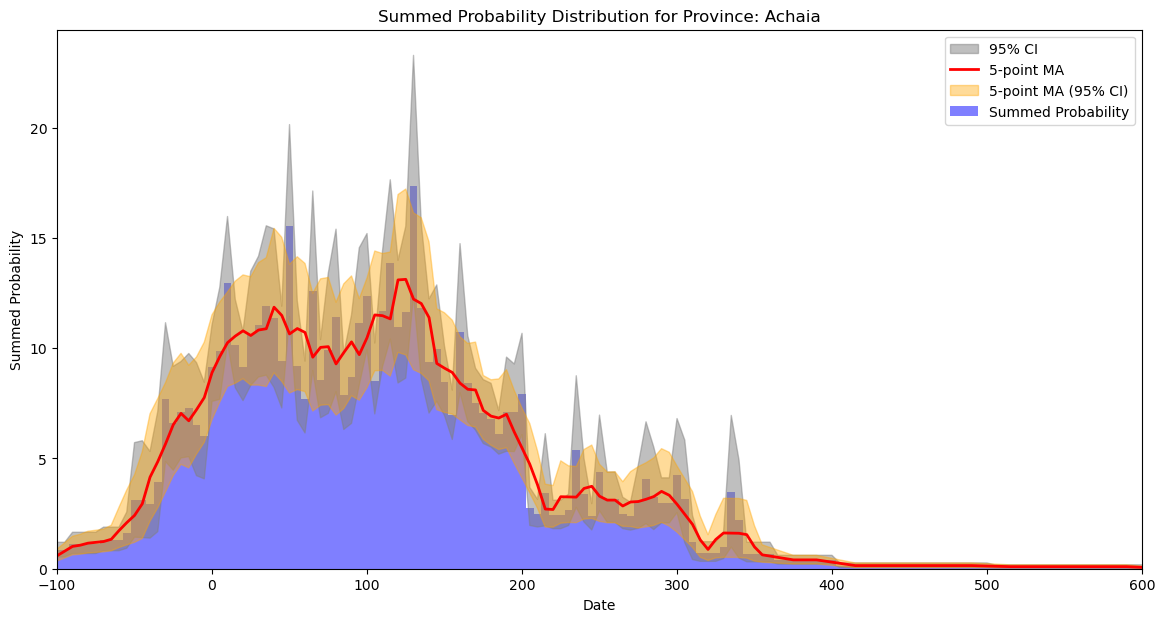


KeyboardInterrupt



In [14]:
# Start summed probability function

def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# End summed probability function

# Initialize parameters
n_iterations = 1000  # Number of bootstrap iterations
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5  # Bin size for the histogram (in years)
window_size = 5  # Define the size of the moving window for the moving average

# Filter to only include provinces with more than 500 inscriptions
selected_provinces = province_counts[province_counts > 500].index.tolist()

# Loop through each selected province
for province in selected_provinces:
    # Filter DataFrame based on the current province
    subset_df = lire[lire['province'] == province]
    
    # Initialize storage for bootstrap results
    bootstrap_summed_probs = None
    
    # Bootstrap sampling
    for i in range(n_iterations):
        bootstrap_sample = subset_df.sample(n=len(subset_df), replace=True)
        bootstrap_summed_prob, _ = compute_summed_probability(bootstrap_sample, earliest_date, latest_date, resolution)
        if bootstrap_summed_probs is None:
            bootstrap_summed_probs = np.zeros((n_iterations, len(bootstrap_summed_prob)))
        bootstrap_summed_probs[i, :] = bootstrap_summed_prob
    
    # Calculate 95% confidence intervals
    lower_bound = np.percentile(bootstrap_summed_probs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_summed_probs, 97.5, axis=0)
    
    # Calculate the summed probability and standard deviations for the subset
    summed_prob, _ = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Generate x-values for plotting
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]

    # Calculate moving average for summed_prob
    moving_avg = uniform_filter1d(summed_prob, size=window_size, mode='nearest')
    
    # Calculate moving average for the lower and upper bounds of the 95% CI
    moving_avg_lower = uniform_filter1d(lower_bound, size=window_size, mode='nearest')
    moving_avg_upper = uniform_filter1d(upper_bound, size=window_size, mode='nearest')
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
    # Plot the 95% confidence intervals
    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='95% CI')
    
    # Plot the moving averages
    plt.plot(x_values, moving_avg, color='red', linestyle='-', linewidth=2, label='5-point MA')
    
    # Add fill_between for the moving averages of the 95% CI
    plt.fill_between(x_values, moving_avg_lower, moving_avg_upper, color='orange', alpha=0.4, label='5-point MA (95% CI)')
    
    plt.title(f"Summed Probability Distribution for Province: {province}")
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()
